In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as st
import statsmodels.datasets
import scipy.optimize as optimize
import copy
import scipy.stats as stats
from scipy.integrate import odeint as ode
from scipy.integrate import odeint

In [2]:
covid19 = pd.read_csv("/Users/likehang/Desktop/covid_19_t.csv")
icu_bed = pd.read_csv("/Users/likehang/Desktop/icu_bed.csv")
age_group = pd.read_csv("/Users/likehang/Desktop/age_group.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")

In [3]:
icu_bed = icu_bed.groupby('State',as_index=False).agg({'ICU_beds':'mean'}).rename({'ICU_beds':'ICU_beds'},axis=1)
probabilities = probabilities.head(9)

In [4]:
bed_map = dict(zip(icu_bed['State'],icu_bed['ICU_beds']))
agegroups_map = dict(zip(age_group['State'],age_group[age_group.columns[1:10]].values))

#  store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

In [5]:
dic = {}
for i in range(1,57):
    df = pd.DataFrame(covid19.iloc[0:215 ,[0,i]])
    level = 'level%d' % i
    dic[level] = {}
    dic[level] = dict(zip(df['day'],df.iloc[:,1]))

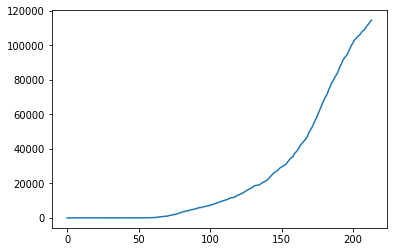

In [6]:
infections = np.ceil(np.array(list(dic['level1'].values())))
plt.plot(infections)
plt.show()

In [7]:
data_g= [i for i in infections if i >0 or i==0]

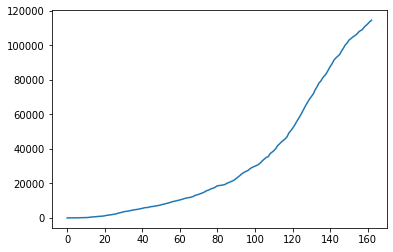

In [8]:
n = next((i for i, x in enumerate(data_g) if x), None)
f = max(n+150,215)
data = np.array(data_g[n:f])
plt.plot(data)
plt.show()

In [9]:
from sklearn import linear_model
#linear regression model
reg = linear_model.LinearRegression(fit_intercept=False)
#use log of infection values
time_steps=np.linspace(0,214, 214, dtype=int)
tot_inf=[i+1 if i==0 else i for i in infections]

logI= np.log(tot_inf)
logI= np.nan_to_num(logI)
time_steps= np.nan_to_num(time_steps)
inf_fit= reg.fit(time_steps.reshape(-1,1), logI)
print(inf_fit)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)


In [10]:
slope=reg.coef_[0]
mu = 0.066

In [11]:
R0= (slope/mu)+1
print('Basic reproductive number is:',R0)

Basic reproductive number is: 2.0088222100061928


In [12]:
def SEIR_num(beta,sigma,gamma,lambd,k,S0,E0,I0,R0,C0,D0,T):

    N = S0 + E0 + I0 + C0 + R0 + D0
    
    S = np.empty(T)
    E = np.empty(T)
    I = np.empty(T)
    C = np.empty(T)
    R = np.empty(T)
    D = np.empty(T)
    
    cum = np.empty(T)
    
    S[0] = S0
    E[0] = E0
    I[0] = I0
    C[0] = C0
    R[0] = R0
    D[0] = D0
    
    cum[0] = 0
    s = 0.003
    
    lst=[]
    for t in range(T-1):
        beta_t = beta * np.exp(-k*t)
        Beds_t = beds_0 + beds_0 *s*t
        lst.append({
            'beta_t': beta_t,
            'Beds_t': Beds_t })
    dn = pd.DataFrame(lst)
    
    for t in range(T-1):
        S[t+1] = S[t] + lambd*N - lambd*S[t] - dn.loc[t,'beta_t']*I[t]*S[t]/N
        E[t+1] = E[t] - lambd*E[t] + dn.loc[t,'beta_t']*S[t]*I[t]/N -sigma*E[t]
        I[t+1] = I[t] - lambd*I[t] + sigma*E[t] - 1/11.0 * p_I_to_C * I[t] - gamma * (1 - p_I_to_C) * I[t]
        C[t+1] = C[t] + 1/11.0 * p_I_to_C * I[t] - 1/7.5 * p_C_to_D * min(dn.loc[t,'Beds_t'], C[t]) - max(0, C[t]-dn.loc[t,'Beds_t']) - (1 - p_C_to_D) * 1/6.5 * min(dn.loc[t,'Beds_t'], C[t])
        R[t+1] = R[t] + gamma * (1 - p_I_to_C) * I[t] + (1 - p_C_to_D) * 1/11.5 * min(dn.loc[t,'Beds_t'], C[t])
        D[t+1] = D[t] + 1/7.5 * p_C_to_D * min(dn.loc[t,'Beds_t'], C[t]) + max(0, C[t]-dn.loc[t,'Beds_t'])
        cum[t+1] = cum[t] + beta_t*I[t]*S[t]/N
        
        dset= pd.DataFrame({'S': S, 'E': E, 'I': I, 'C': C, 'R': R, 'D': D, 'cum': cum}, 
                                  columns=['S', 'E','I','C','R','D','cum'])

    
    return dset


In [15]:
def log_likelihood_cumulative(data,simu,d):
    for o, lam in zip(data,d*simu):
        lk = [k*math.log(lam) -lam -sum([math.log(j+1) for j in range(int(o))])]
    return np.sum(lk)

In [16]:
def log_likelihood_worstcase(data,simu,d):
    lk = [k*math.log(lam) -lam -sum([math.log(j+1) for j in range(int(o))]) for o,lam in zip(data,d*simu)]
    return min(lk)

In [17]:
agegroups = agegroups_map['Alabama']
agegroups_n = agegroups / np.sum(agegroups)
beds_0 = int(bed_map['Alabama'])

In [18]:
p_I_to_C = np.average(prob_I_to_C_1, weights = agegroups_n)
p_C_to_D = np.average(prob_C_to_Death_1, weights = agegroups_n)

In [19]:
def SEIR_estimation(d,beta,k,dels,data):
    S0 = sum(agegroups)
    E0 = 0.002 * S0
    R0 = 0
    I0 = data[0]
    C0 = 0
    D0 = 0
    sigma = 0.196
    gamma = 0.1
    lambd = 0.0
    s = 0.003
    
    T = len(data)+max(dels)+1
    
    df = pd.DataFrame()
    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            dset = SEIR_num(beta[i],sigma,gamma,lambd,k[h],S0,E0,I0,C0,R0,D0,T)
            dset['beta'] = beta[i]
            dset['k'] = k[h]
            df = df.append(dset)
    return df

In [22]:
def SEIR_likelihood(d,beta,k,dels,data):
    df = SEIR_estimation(d,beta,k,dels,data)
    dataset = pd.DataFrame()
    for l in range(len(beta)):
        dt = df[df['beta']==beta[l]]
        for e in range(len(k)):
            dp = dt[dt['k']==k[e]]
            dp = dp[['cum']].astype(int)
            dp = dp.values
            likelihood = []
            for j in range(len(d)):
                a = [log_likelihood_cumulative(data,dt[int(delay):int(delay)+len(data)],d[j]) for delay in dels]
                lk = np.amax([log_likelihood_cumulative(data,dt[int(delay):int(delay)+len(data)],d[j]) for delay in dels])
                likelihood.append({
                    'beta': beta[l],
                    'd': d[j],
                    'max_likelihood': lk,
                    'max_delay': dels[a.index(max(a))]       
                })
                dset_1 = pd.DataFrame(likelihood)
                dataset = dataset.append(dset_1)
        dataset = dataset.drop_duplicates()
        return dataset

In [ ]:
dels = [i for i in range(3,8)]
k = [0.001, 0.002]
d = [ round(elem, 2) for elem in np.arange(0.1,1,0.1) ]
beta = [ round(elem, 2) for elem in np.arange(0.1, 0.5, 0.1) ]

dataset = SEIR_likelihood(d,beta,k,dels,data)

plt.figure(figsize=(12,10))
d = dataset['d'].unique()
for i in range(len(d)):
    dc = dataset.loc[dataset['d']== d[i]]
    plt.plot(dc['beta'], dc['max_likelihood'], label='Likelihood with d={}'.format(d[i]))
plt.legend()
plt.show()

In [38]:
dl = dataset['d'].unique()
ds = pd.DataFrame()
for i in range(len(d)):
    dc = dataset.loc[dataset['d']== dl[i]]
    de = dc[dc['max_likelihood']==dc['max_likelihood'].max()]
    ds = ds.append(de)

In [39]:
ds = ds.sort_values(by ='max_likelihood',ascending=False)
ds = ds.head(10)
ds

,beta,d,max_likelihood,max_delay
19,0.10,1.00,-422.260195,10
18,0.10,0.95,-1044.433788,10
17,0.10,0.90,-1984.310775,10
16,0.10,0.85,-3278.228229,10
0,0.15,0.05,-3345.577196,10
15,0.10,0.80,-4969.137414,10
14,0.10,0.75,-7108.313317,10
1,0.15,0.10,-7565.096553,2
13,0.10,0.70,-9757.654875,10
12,0.10,0.65,-12992.839141,10


In [20]:
dj = dj.drop(['S','beta'], axis = 1)
data = pd.DataFrame(data)

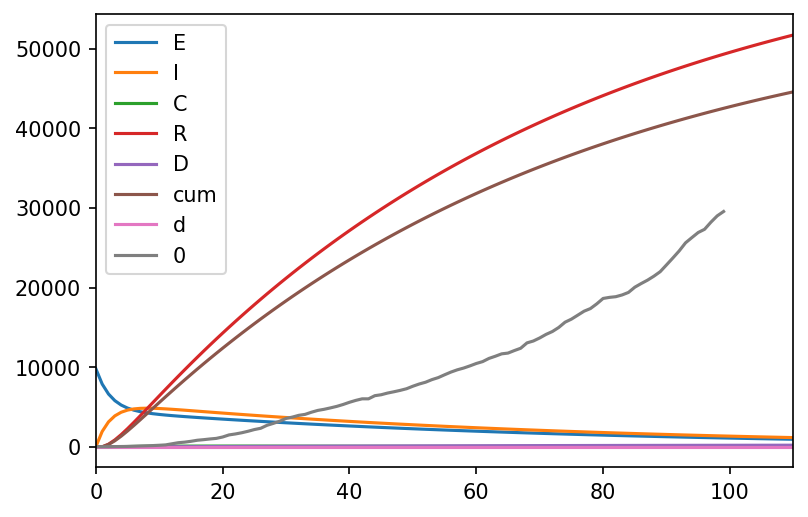

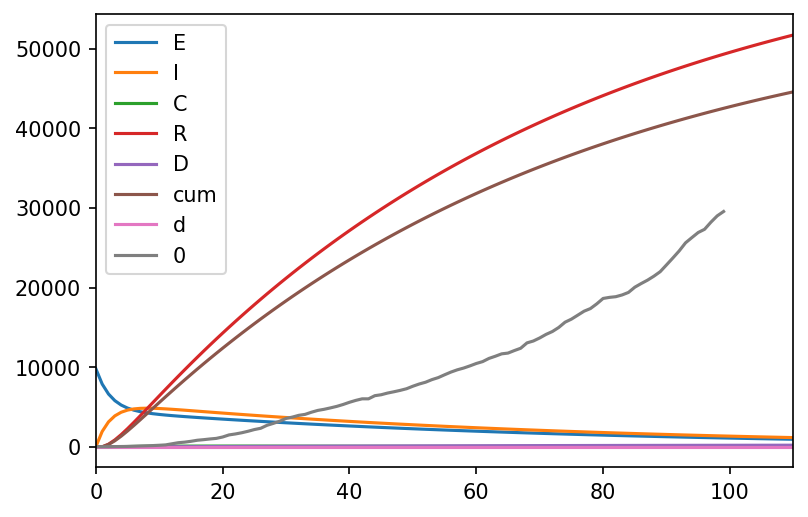

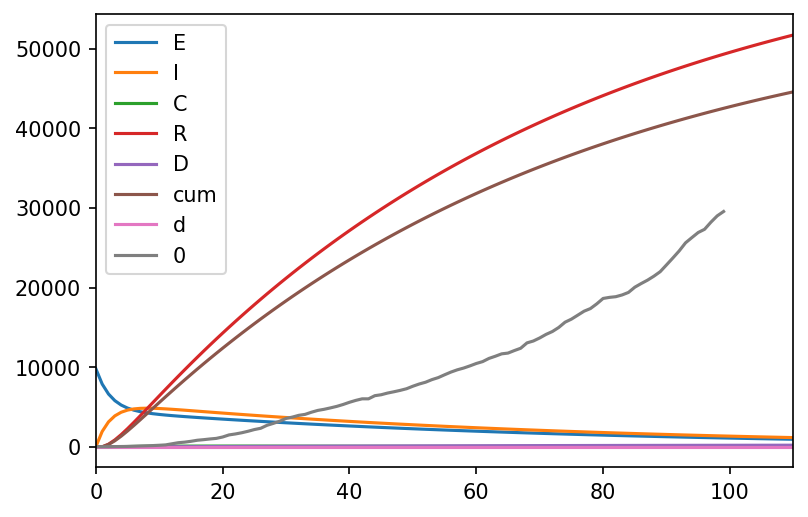

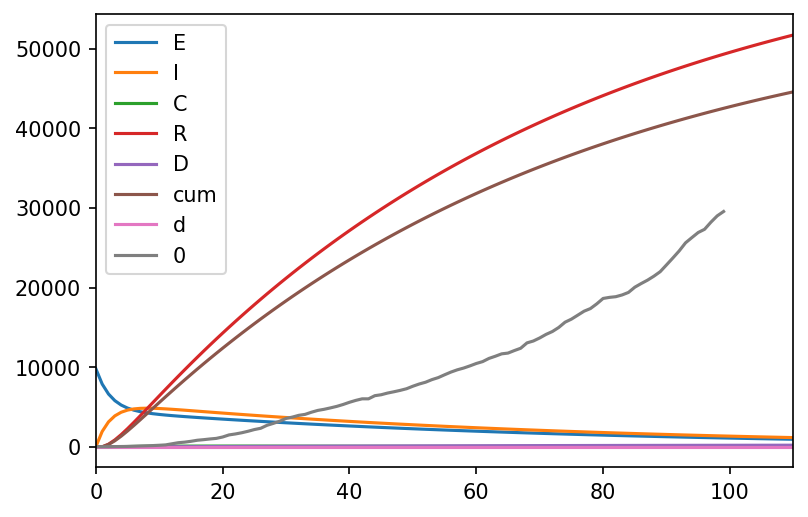

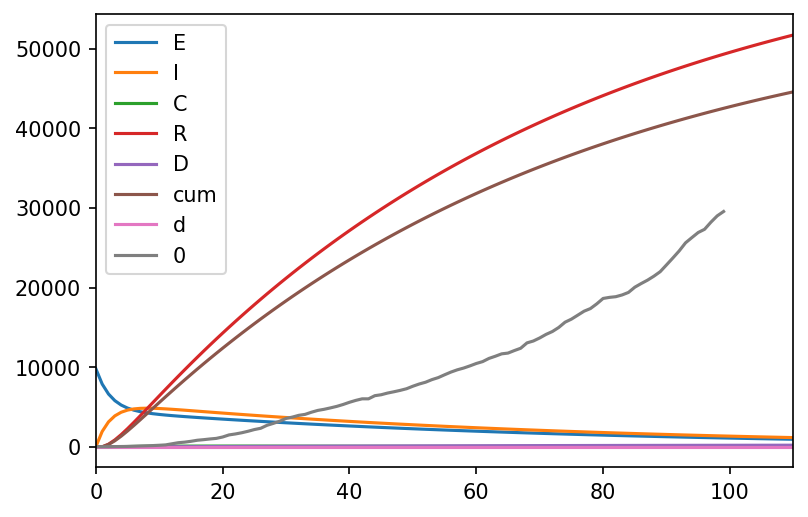

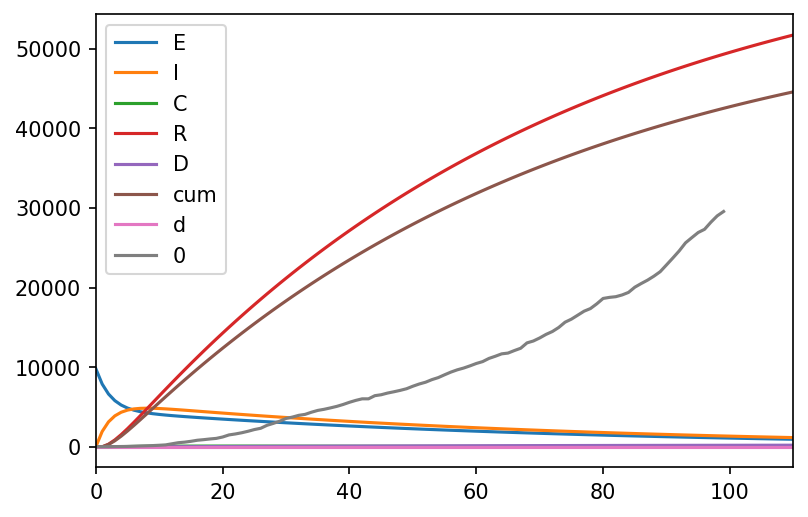

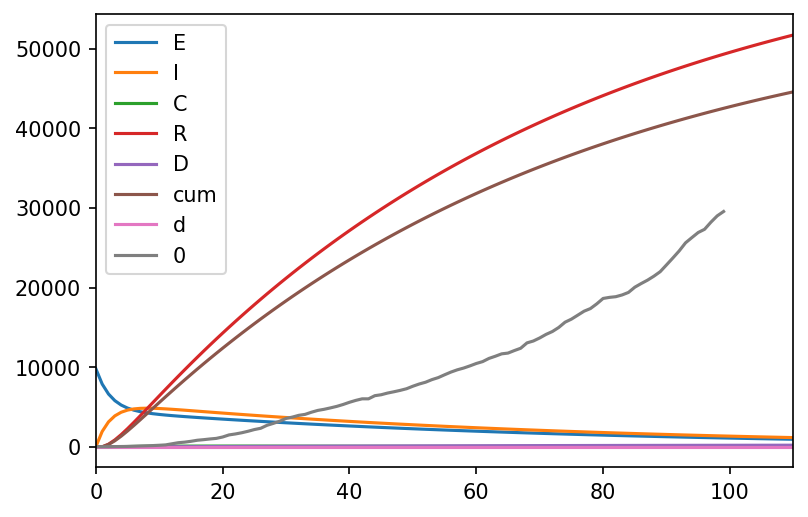

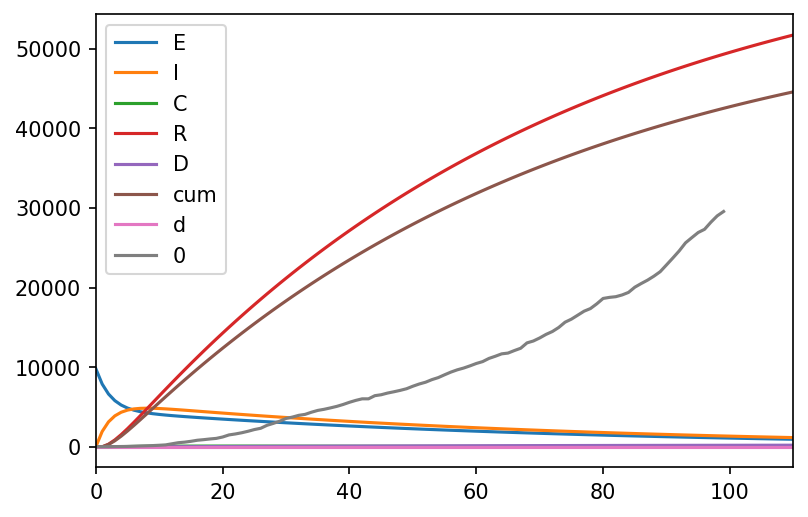

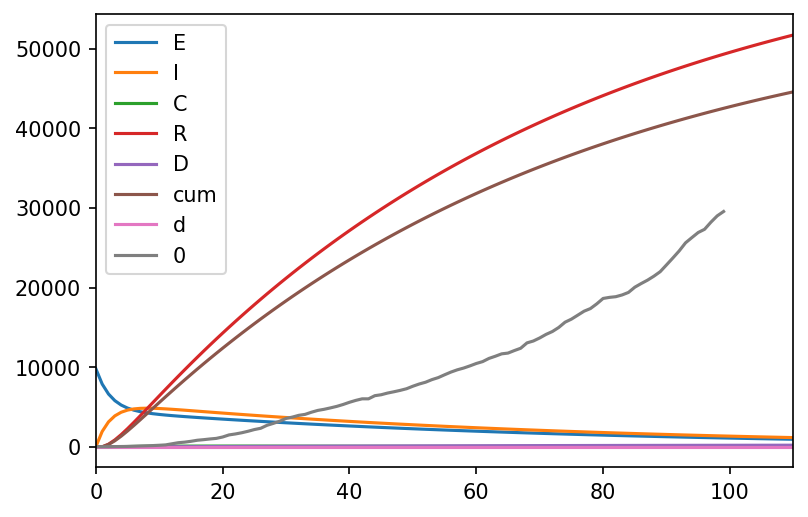

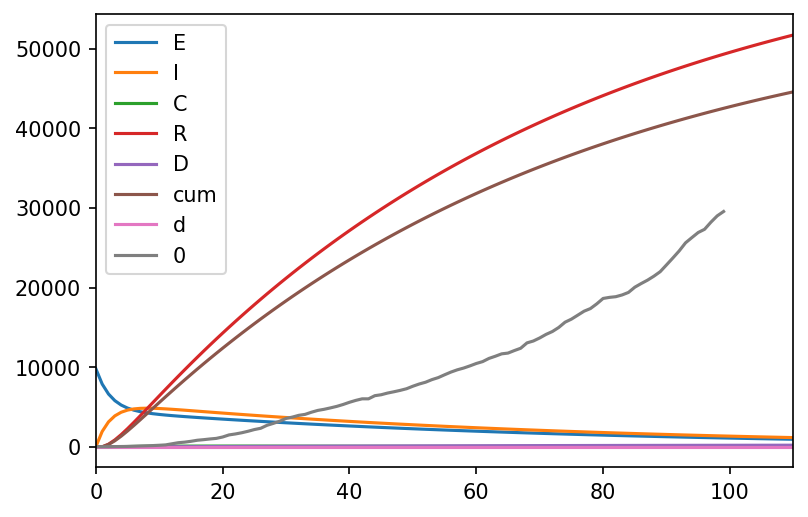

In [21]:
d = dj['d'].unique()
for i in range(len(d)):
    dc = dj.loc[dj['d']== d[i]]
    fig = plt.figure(dpi = 150)
    ax = fig.gca()
    dc.plot(ax = ax)
    data.plot(ax = ax)

